# A statistical analysis of droplets generated in ensembles of randomly corrugated ligaments

We study the statistical description of droplet sizes, created as a result
of capillary-induced breakup of ligaments. **Direct numerical simulations** of *air-water systems*
are employed by solving the two-phase Navier-Stokes equations on adaptive Octree grids
[Basilisk](http://basilisk.fr/), using the VOF methodology coupled with height function based
curvature modeling. Breakup of individual ligaments are triggered by initial surface
corrugations, the dynamics of which are deterministic. **Stochasticity** is introduced in the mix
by conducting an *ensemble of simulations* of slender corrugated ligaments, each realization
corresponding to a **random but unique initial configuration**. Probability density functions of
the droplet sizes are computed for different ensemble sizes. Thus, by combining
the effects of stochasticity with the capillarity-driven non-linear dynamics, we can improve our understanding of the nature of drop size distributions encountered in realistic
and convoluted fluid fragmentation scenarios.

> #### TL;DR 
> - corrugated water ligaments in air (~ 100,000's) 
> - ligaments breakup due to complicated effects 
> - ensembles of drops generated (~1000,000's) 
> - probability distributions of drops?   


## Problem Setup 
We have an air-water configuration, thus for the given material properties the length scale of our problem is governed by 

$$ \textrm{Oh}= \frac{\mu}{\sqrt{\rho \sigma R}} \quad , \quad \Lambda = L/W \,.$$
> The reference density and viscosity correspond to the liquid. 

As we do not incorporate any axial stretching rate or initial velocity distribution inside the ligament, our setup can be understood to be at the limit of $\textrm{We} \to 1$ . 

### Computational Domain
The ligament is placed in a square domain of size $L$, with a mean radius $R$. The radial profile along the axial direction is given by 

$$ R(x) = R + \epsilon(x) \quad , \, \text{where} \quad  \epsilon \sim \mathcal{N}(0,\lambda_0^2) $$

The schematic of the computational setup is shown below -

<img src="./schematic.png" style="width: 500px;" align="center" />

### Surface generation
We deal with slender ligaments (i.e. length >> diameter), and we impose periodicity along the axial direction. The surface (radial profile) of this axisymmetric ligament is generated by superposing waves of different wavelenghts, the amplitudes of which are **normally distributed**. This newly generated surface is passed through a **low-pass filter**, which allows us to smoothen the profile and circumvent the extremely sharp peaks/kinks on the surface (our solvers don't like discontinuous derivatives). An example of the surface generation and subsequent filtering is shown below -

<img src="./profile.png" style="width: 600px;" align="center"/>


Thus, we can clearly see that by filtering out all but the $n_c$ longest discrete waves, the final shape of the ligament can be characterized by 

$$ K = n_c \cdot (2\pi W/L) \quad , \quad \varepsilon = \lambda / R \,. $$

> $\lambda_0$ corresponds to the un-filtered surface, while $\lambda$ corresponds to the filtered one. 

#### Energy supplied to discrete modes 
Contrary to the continuous problem, in our numerical simulations we can only inject energy into a **discrete** set of wavenumbers, as demonstrated below using the dispersion relation for the canonical Rayleigh-Plateau instability. 

<img src="waves.png" style="width: 600px;" align="center" />

Thus, the total number of wavenumbers perturbed in the unstable part of the spectrum is 

$$ \Delta k = \Lambda/\pi - 1 $$

Thus, instead of the infinite number of continuous wavenumbers in the unstable part of the spectrum interacting amongst themselves, we get only a handful of them in our discrete setup. At a later part of the analysis, we will see if this any meaningful impact on the size distributions of the drops formed.

### Destabilization of an individual ligament

Let us rescale our physical time $t$ using the capillary timescale at the length scale $R$ of the ligaments. Thus, our time variable is now given by 

$$ T = t \cdot \left(\rho R^3 / \sigma \right)^{-1/2} $$

As an example, we choose a millimeter scale ligament, whose surface is *weakly perturbed*. It should be noted that **all** of the individual ligaments in this particular **ensemble** are characterized by $\Phi$, which is defined as 

$$ \Phi = \left(\textrm{Oh} = 10^{-2}, \varepsilon \approx 0.04 , K = 2\pi , \Lambda = 50 \right) \,.$$

> $\Phi$ acts as a point in the parameter space of all possible corrugated ligament configurations. 

The shape of the ligament initially evolves as per the exponential growth phase well described by linear perturbation theory. Once the perturbations attain a certain amplitude, the non-linear growth kicks in, given by the energy tranfers between different frequencies. The animation below shows the temporal evolution of the ligament, which eventually breaks up into drops, which themselves might undergo coalescence with neighbouring drops. 

![animation](./ligament_breakup.gif)

The colormap on the top half represents the axial velocity, whereas the bottom half corresponds to vorticity. 

## Exploratory Data Analysis 

We have datasets corresponding to variation in the following parameters of the ligament ensemble
- Strongly perturbed and weakly perturbed : $\varepsilon = \{0.038, 0.076\}$
- Smaller and larger aspect ratios : $\Lambda = \{50,100\}$

We start by loading the required libraries, and set the plotting styles. 

In [30]:
# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']
#sns.set(style="white", palette="muted")
sns.set_context("paper")


All of the datasets are concatenated onto a single, structured, ASCII format data file. 

In [31]:
drops = pd.read_csv("results", sep=" ")

This is how the dataset looks ! 

In [32]:
drops.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


What is the total size of the dataset ? 

In [33]:
drops.shape

(3653802, 13)

We have approximately 3.6 millions data points after combining the 4 datasets. Let us create separate copies of the 4 distinct datasets which are mixed in the original one. 

In [34]:
# low amplitude , low aspect
d1 = drops.loc[(drops.amplitude == 0.1) & (drops['aspect-ratio'] == 50)]

# low amplitude , large aspect
d2 = drops.loc[(drops.amplitude == 0.1) & (drops['aspect-ratio'] == 100)]

# large amplitude , low aspect 
d3 = drops.loc[(drops.amplitude == 0.2) & (drops['aspect-ratio'] == 50)]

# large amplitude , large aspect
d4 = drops.loc[(drops.amplitude == 0.2) & (drops['aspect-ratio'] == 100)]

Let us check if they are correctly sorted. 

In [35]:
d1.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


In [36]:
d2.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
772889,0.01,100,0.25,0.1,0,1,98.9443,0.000000,201.87100,16.03620,2158.17000,200.000,8296
772890,0.01,100,0.25,0.1,6,1,98.7653,-0.000011,210.79200,16.38670,2302.80000,200.000,740
772891,0.01,100,0.25,0.1,12,1,98.9456,0.000172,208.46600,16.29610,2264.78000,200.000,1254
772892,0.01,100,0.25,0.1,18,1,98.8410,0.000161,207.25700,16.24870,2245.11000,200.000,2354
772893,0.01,100,0.25,0.1,24,1,197.4140,0.013180,5.60521,2.67215,9.98533,-186.751,90


In [37]:
d3.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
1680726,0.01,50,0.5,0.2,0,1,48.9594,0.000000,101.725000,11.383600,771.997000,100.00000,7758
1680727,0.01,50,0.5,0.2,6,1,48.9057,-0.000527,103.445000,11.479400,791.660000,100.00000,1397
1680728,0.01,50,0.5,0.2,12,14,84.3172,0.002377,30.222700,6.204860,125.019000,69.86240,701
1680729,0.01,50,0.5,0.2,12,13,70.8915,2.326830,0.243942,0.557453,0.090658,13.42570,66
1680730,0.01,50,0.5,0.2,12,12,64.4259,0.084844,8.234140,3.238730,17.778700,6.46556,191


In [38]:
d4.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
2580588,0.01,100,0.25,0.2,0,1,97.9285,0.000000,203.68700,16.10820,2187.36000,200.0000,7837
2580589,0.01,100,0.25,0.2,6,1,97.9144,-0.000042,211.31300,16.40700,2311.34000,200.0000,799
2580590,0.01,100,0.25,0.2,12,1,97.6819,-0.000663,209.08300,16.32010,2274.84000,200.0000,1971
2580591,0.01,100,0.25,0.2,18,12,166.1750,0.026505,62.36370,8.91315,370.57200,150.4680,813
2580592,0.01,100,0.25,0.2,18,11,119.5590,0.304221,3.75126,2.18602,5.46688,46.6159,129


Let us select a few **time slices** for our first dataset. 

Plotting the histograms for these time slices - 

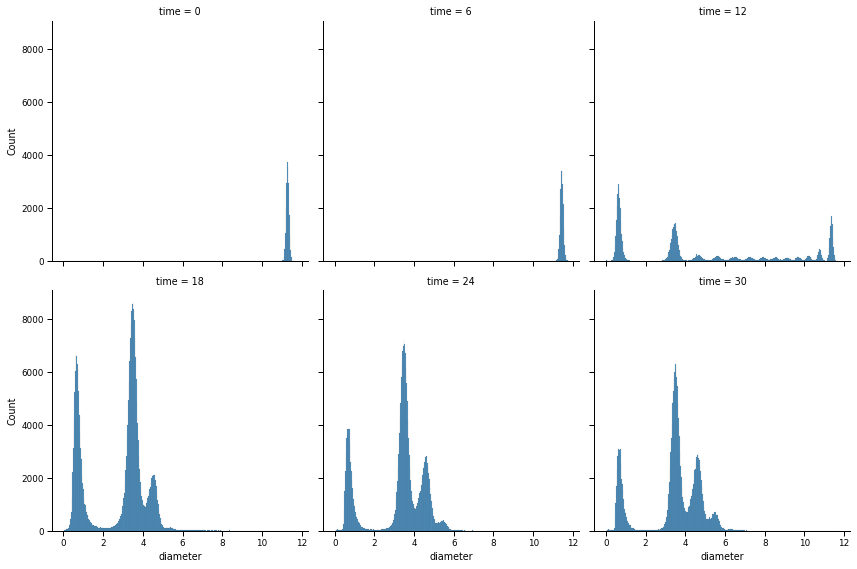

In [39]:
sns.displot(data=d1, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3)


We observe that the distributions before t=18 are not very interesting, because the ligament still has not broken down into the drops. Let us concentrate on T=18.

In [40]:
d1_t18 = d1.loc[d1["time"] == 18]
d1_t18.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.371500,3.634850,25.132700,27.09410,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.899200,1.555430,1.969380,9.21340,181
5,0.01,50,0.5,0.1,18,11,78.8851,0.182200,18.298100,4.828020,58.895800,5.63490,364
6,0.01,50,0.5,0.1,18,10,65.0789,0.126383,8.742510,3.337210,19.450400,13.80620,196
7,0.01,50,0.5,0.1,18,9,60.5704,0.177399,0.302186,0.620443,0.124993,4.50848,38


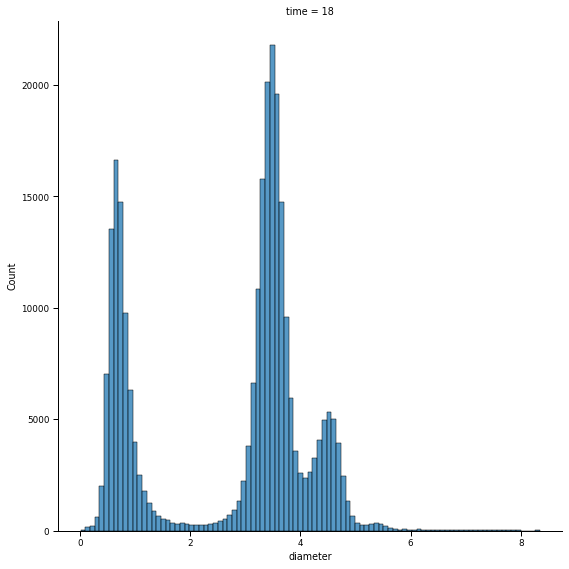

In [41]:
sns.displot(data=d1_t18.loc[d1.time == 18], kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=8.0, aspect=1.0)
#plt.axvline(x = 4, color='black', label = "mean")
#plt.legend()

Let us compute the values for the **equivalent diameters**, which can be simply estimated by equating the volume under our *discrete* wavelengths ($L_i$) to the volume of a drop with diameter $D_i$. Thus we get 

$$ \pi D_i^3 /6 = \pi R^2 L_i \quad \implies D_i = (6 L_i R^2 )^{1/3} $$ 

We also rescale the the diameters with the intial width of the ligament $W$. That gives us 

$$ D_i / W = \left(3\Lambda /2i \right)^{1/3} \, $$ where $i$ varies between $1-50$ for our case (first 50 longest waves chosen). 


Thus, we can push these changes to see what happens 